In [25]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import ARIMA, TSCV
from src.ploting import LinearPlot, DistPlot, ACFPlot, QQPlot
from src.utils import GridSearch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import jarque_bera
from scipy import stats

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

In [2]:
CURRENCY = "EURUSD"
INTERVAL = "15m"

In [3]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

PACF plot of target_value variable

/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

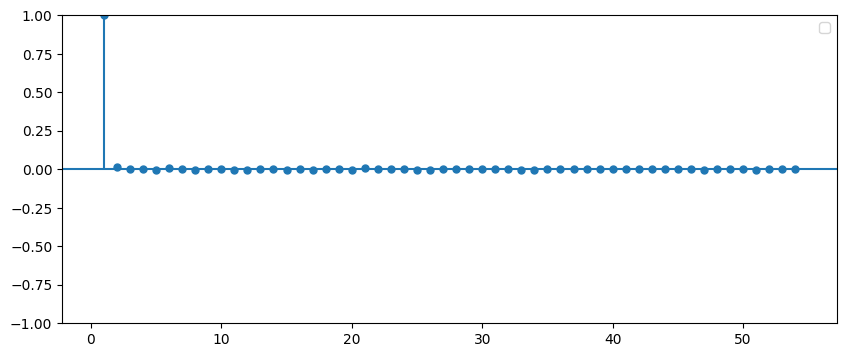

In [4]:
ACFPlot(legend=True).plot(train['target_value'], partial=True, legend="ACFPlot")

Durbin Watson test for lag 1 autocorrelation

In [5]:
durbin_watson(train['target_value'])

2.8383562e-07

ADfuller test for stationarity

In [12]:
for k in range(4):
    ts = train['target_value'].diff(k).dropna() if k !=0 else train['target_value']
    adf_res = adfuller(ts)
    print(f"k={k}, p-value: {adf_res[1]}, adf statistic: {adf_res[0]}")

k=0, p-value: 0.10178444605420228, adf statistic: -2.5589375355417663
k=1, p-value: 0.0, adf statistic: -113.5362999228737
k=2, p-value: 0.0, adf statistic: -54.1969199226378
k=3, p-value: 0.0, adf statistic: -53.50102029630235


In [14]:
ts = train['target_value'].diff(1).dropna()
adf_res = adfuller(ts)
print(f"k={1}, p-value: {adf_res[1]}, adf statistic: {adf_res[0]}")

k=1, p-value: 0.0, adf statistic: -113.5362999228737
k=2, p-value: 0.0, adf statistic: -54.1969199226378


In [15]:
ts = train['target_value'].diff(2).dropna()
adf_res = adfuller(ts)
print(f"k={2}, p-value: {adf_res[1]}, adf statistic: {adf_res[0]}")

k=2, p-value: 0.0, adf statistic: -54.1969199226378


# ARIMA

In [8]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=20,
            test_size=5)
tscv.run(ARIMA(), p=2, d=1, q=4)

split: 1/3
split: 2/3
split: 3/3


{'mean_absolute_percentage_error': 0.0007466605291161979,
 'rmspe': 0.000838866378584777}

In [23]:
tscv.model.model_fit.summary()

KeyboardInterrupt: 

<Axes: title={'center': 'ARIMA'}>

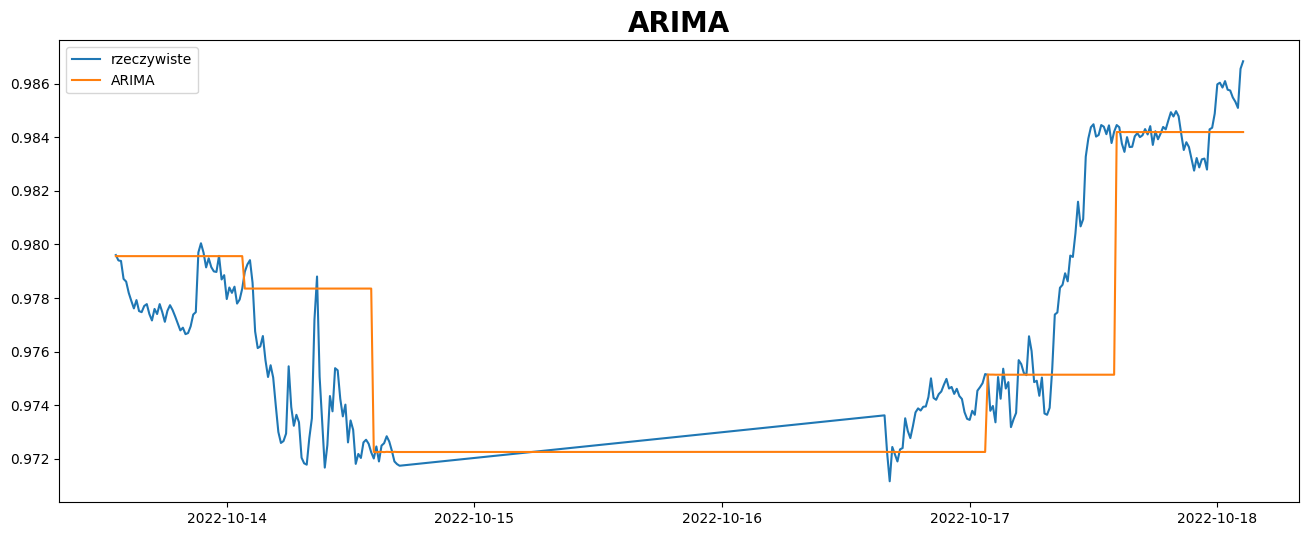

In [40]:
pred_y = tscv.predicted
x = tscv.dataset.data.index[-len(pred_y):]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(x, tscv.dataset.data.loc[x, 'target_value'], label="rzeczywiste", title="ARIMA")
lp.plot(x, pred_y, label="ARIMA")

# GridSearch ARIMA

In [7]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=20,
            test_size=5) 

warnings.filterwarnings('ignore')
gs = GridSearch(model=ARIMA(),
                tscv=tscv,
                params={'p': [1, 2, 3, 4, 5, 6, 7], 'd': [1], 'q': [1, 2, 3, 4, 5, 6, 7]},
                by=['rmspe'],
                p_count=5)
# gs.run() # already been run, best model: ARIMA(2, 1, 4)

# Model evaluation

In [4]:
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=5)
tscv.run(ARIMA(), p=2, d=1, q=4)

split: 1/3
split: 2/3
split: 3/3


{'mean_absolute_percentage_error': 0.002140543407608655,
 'rmspe': 0.0028841502400008545}

In [5]:
resid = tscv.model.model_fit.resid[1:]

### Residuals distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt ARIMA
saving: Wykres liniowy reszt ARIM


<Axes: title={'center': 'Wykres liniowy reszt ARIM'}>

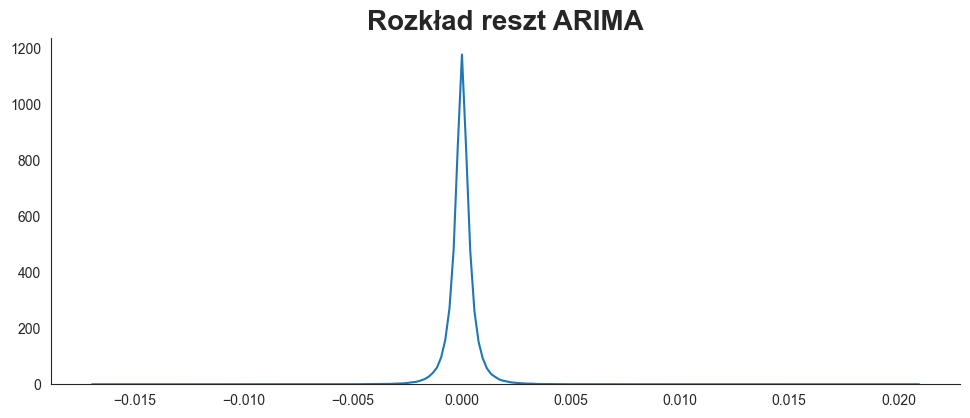

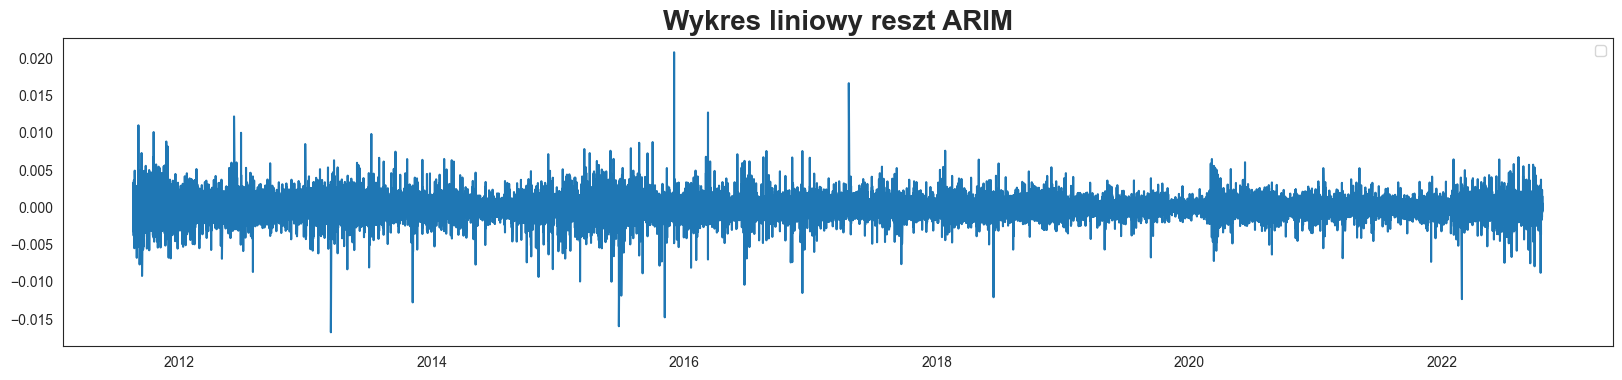

In [6]:
DistPlot().plot(resid, title="Rozkład reszt ARIMA")
LinearPlot(w=20).plot(tscv.dataset.train.index[1:], resid, title="Wykres liniowy reszt ARIM")

In [7]:

jarque_bera(resid)

SignificanceResult(statistic=9869872.949989887, pvalue=0.0)

In [8]:
ind = np.argpartition(np.abs(resid), -100)[-100:]
top_100 = resid[ind].sort_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt ARIMA
saving: Wykres liniowy reszt ARIM


<Axes: title={'center': 'Wykres liniowy reszt ARIM'}>

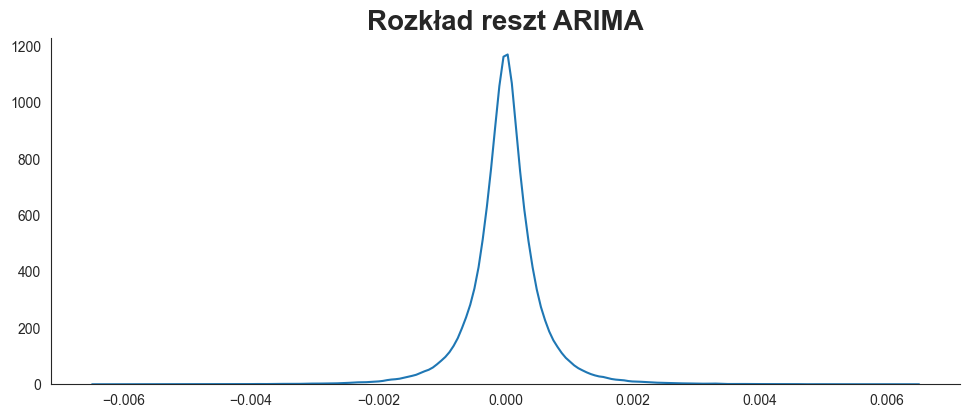

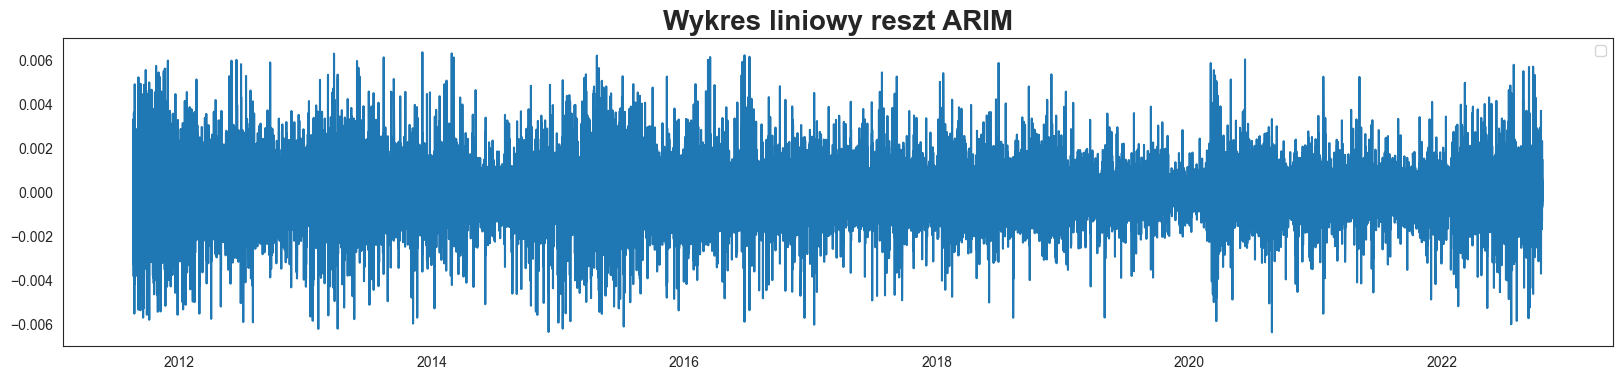

In [9]:
r_2 = resid.drop(index=top_100.index)
DistPlot().plot(r_2, title="Rozkład reszt ARIMA")
LinearPlot(w=20).plot(r_2.index, r_2, title="Wykres liniowy reszt ARIM")

In [10]:
jarque_bera(resid)

SignificanceResult(statistic=9869872.949989887, pvalue=0.0)

In [11]:
print(f"skewenes: {stats.skew(resid)}\nkurtosis: {stats.kurtosis(resid)}")

skewenes: -0.039160365299973014
kurtosis: 29.23606079395823


### Residuals autocorrelation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


saving: ACF reszt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: PACF reszt


<Axes: title={'center': 'PACF reszt'}>

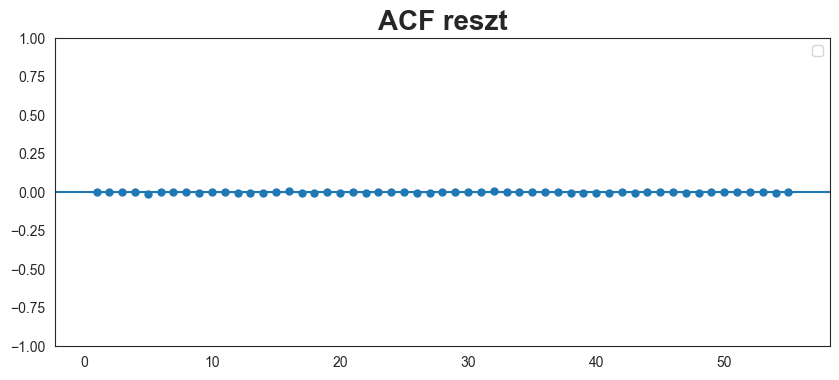

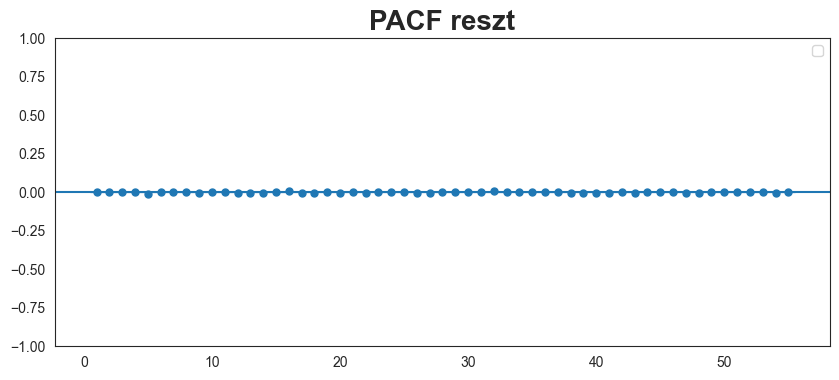

In [12]:
ACFPlot().plot(resid, title="ACF reszt")
ACFPlot().plot(resid, title="PACF reszt", partial=True)

In [13]:

durbin_watson(resid)

2.0002075949789897

### Heteroskedasticity 

saving: Wykres kwantylowy


<Axes: title={'center': 'Wykres kwantylowy'}, xlabel='Reszty teoretyczne', ylabel='Reszty rzeczywiste'>

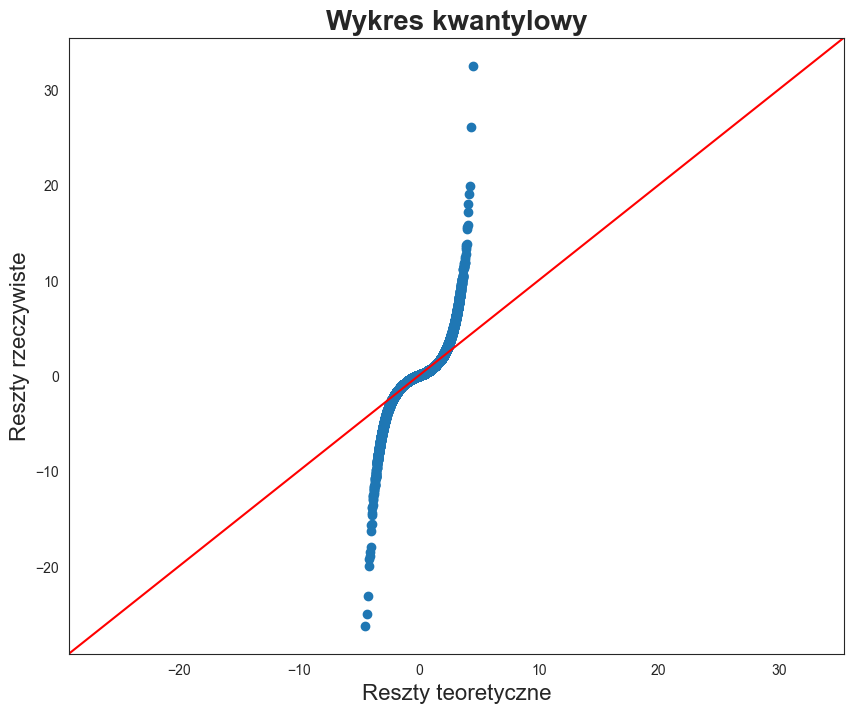

In [35]:
QQPlot(legend=False, w=10, h=8).plot(resid, title="Wykres kwantylowy", xlabel="Reszty teoretyczne", ylabel="Reszty rzeczywiste")

In [15]:
het_breuschpagan(resid, tscv.dataset.train[['Close', 'target_value']].iloc[1:])

(8658.006531606448, 0.0, 4468.578420869463, 0.0)